# ทำนายผลผลิตการเกษตร โดยใช้ผลผลิตปีก่อน ๆ ด้วย Prophet

https://facebook.github.io/prophet/docs/quick_start.html

ขั้นตอนติดตั้ง ให้สร้าง environment ที่ชื่อ oae โดยใช้ environment.yml
และคัดลอกข้อมูล OAE-process มาไว้ใน folder นี้

In [27]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from fbprophet.plot import plot_plotly, plot_components_plotly

from utils.preprocess import read_yield, get_yeild_area, read_annually_data, read_month_data, read_month_data_area, add_regressor

py.init_notebook_mode(connected=True)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import datetime

from config import params 

eps = 1e-16

Model parameters

In [28]:
print(list(params.keys()))

['rice_in-season', 'rubber', 'rice_off-season', 'palm', 'coffee', 'corn', 'cassava', 'longan', 'durian', 'pineapple', 'rambutan', 'mangosteen', 'cane', 'coconut']


## User Param: Select Product Type

วิธีใช้ ขั้นที่ 1: เลือกชนิดของผลผลิตทางการเกษตรที่ต้องการ ในตัวแปร `ptype` เช่น ข้าวนาปี (rice_in-season), ข้าวนาปรัง (rice_off-season), ข้าวโพด (corn), ปาล์มน้ำมัน (palm), มันสำปะหลัง (cassava)

In [29]:
ptype = 'cane'

In [30]:
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
col_price = param['col_price']
is_harvest_season = param['harvest']

In [31]:
df, df_group = read_yield(yield_file)

df_cost = []
for cost_f in cost_file:
    df_cost.append(read_annually_data(cost_f))

precipitation_file = 'Clean13products/ปริมาณน้ำฝน - เขื่อน/ปริมาณฝนตก(RT2244)_clean.xlsx'
df_precip = pd.read_excel(precipitation_file)
df_precip['date'] = df_precip['date'].apply(lambda x: datetime.datetime(x.year-543, x.month, x.day))

df_price = []
for price_f in price_file:
    df_price.append(read_month_data(price_f))

In [32]:
Province = df_group.index[0]
Province

'Nakhon Sawan'

In [40]:
df_yield = get_yeild_area(df, Province)
print(f'Total Yield from {df.date.min().strftime("%b %Y")} to {df.date.max().strftime("%b %Y")} = {df_group.loc[Province,"value"]}')

df_precipitation = read_month_data_area(df_precip, Province)

Total Yield from Jan 2012 to Jan 2014 = 25336370.0


<AxesSubplot:xlabel='ds'>

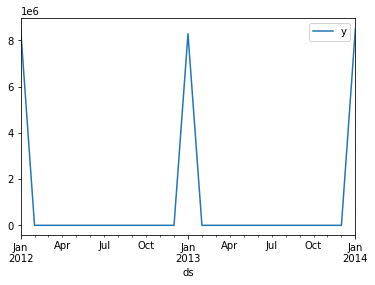

In [42]:
df_yield.plot(x='ds', y='y')

In [34]:
df_precipitation

,y
ds,
1979-01-01,0.100000
1979-01-02,0.500000
1979-01-03,0.000000
1979-01-04,59.020000
1979-01-05,54.030000
...,...
2020-01-08,195.780000
2020-01-09,233.769833
2020-01-10,149.539500


In [35]:
col_regressor = [f'cost{i+1}' for i in range(len(df_cost))] + ['precipitation'] + col_price
@add_regressor([*df_cost, df_precipitation, *df_price], col_regressor)
def add_features(df):
    return df

In [36]:
df_train, df_test = df_yield[:-12], df_yield[-12:]
df_train = add_features(df_train).fillna(0)
if is_harvest_season:
    df_train = df_train.apply(is_harvest_season, axis=1)

df_yield['year'] = pd.DatetimeIndex(df_yield['ds']).year
print(df_yield.groupby('year').sum().head())

model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.seasonality_prior_scale = param['seasonality_prior_scale']

if is_harvest_season:
    model.add_seasonality(name = 'monthly_harvest_season', 
                          period = 30.5, 
                          fourier_order = param['fourier_order'], 
                          condition_name = 'harvest_season')

for col in col_regressor:
    model.add_regressor(col, 
                        prior_scale = param['prior_scale'], 
                        mode = 'multiplicative')

model.fit(df_train)

future = model.make_future_dataframe(periods=24, freq="MS")
future = add_features(future).fillna(0)

if is_harvest_season:
    future = future.apply(is_harvest_season, axis=1)

forecast = model.predict(future)
forecast.yhat.clip(lower=0, inplace=True)
# forecast = forecast.sort_values(by='ds').reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


              y
year           
2012  8546336.0
2013  8283369.0
2014  8506665.0



Predict Yield from Feb 2013 to Jan 2014
RMSE: 2559052.77
MAE: 2228212.71
Total Error: 163.930 %
Forecast: 22451622.73
Ground Truth: 8506665.0


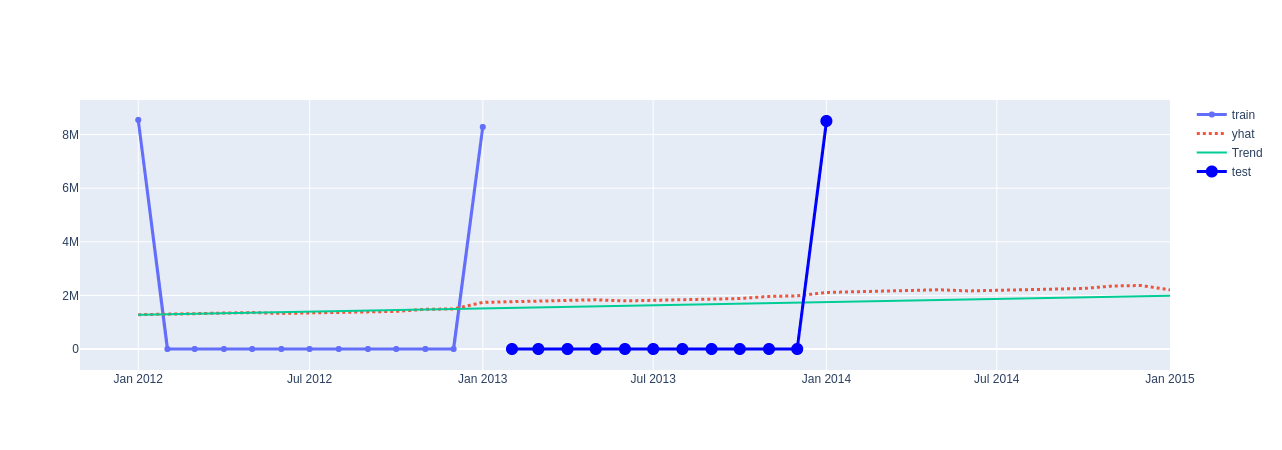

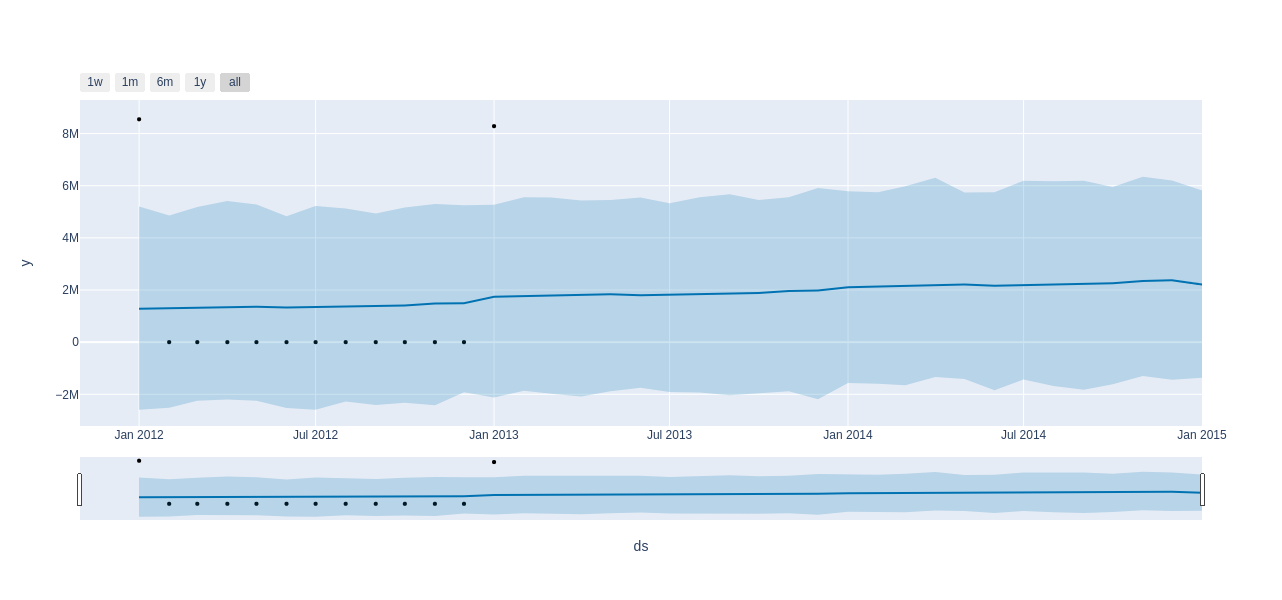

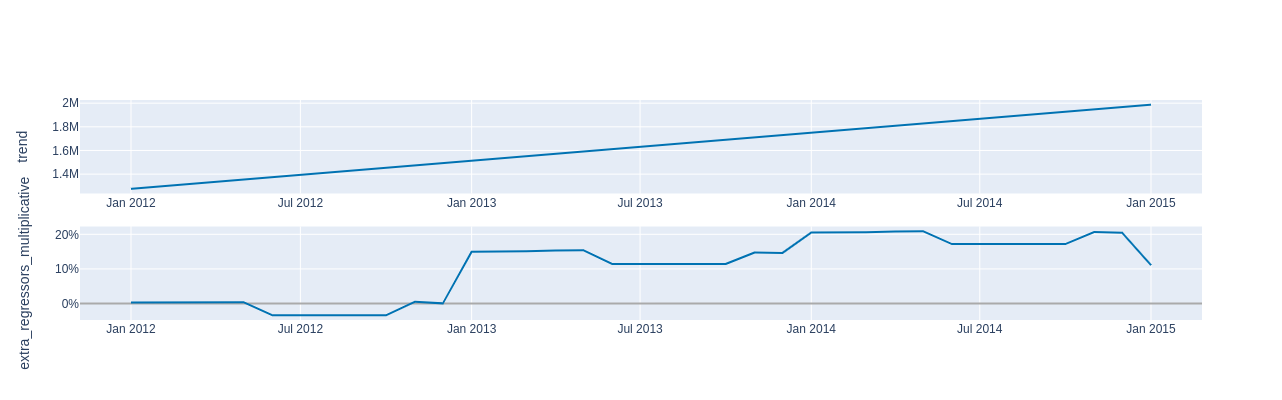

In [37]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[-24:-12]['ds'].to_numpy() == df_test['ds'].to_numpy()))
residuals = forecast[-24:-12]['yhat'].to_numpy() - df_test['y'].to_numpy()
    
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
total_error = abs(1 - (np.sum(forecast[-24:-12]['yhat'].to_numpy()) / (np.sum(df_test['y'].to_numpy())+eps))) * 100

# Calculate root mean squared error.
print(f'\nPredict Yield from {df_test["ds"].min().strftime("%b %Y")} to {df_test["ds"].max().strftime("%b %Y")}')
print('RMSE: %.2f' % rmse )
print('MAE: %.2f' % mae )

print(f"Total Error: {total_error:.3f} %")
print(f"Forecast: {np.sum(forecast[-24:-12]['yhat'].to_numpy()):.2f}")
print('Ground Truth:', np.sum(df_test['y'].to_numpy()))

py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train', line=dict(width=3)),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat', line=dict(width=3, dash = 'dot')),
#         go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
#         go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test', marker=dict(color='blue', size=12), line=dict(width=3)),
])

py.iplot(plot_plotly(model, forecast))

py.iplot(plot_components_plotly(model, forecast))